## Figures & Statistics for the Paper:
# Portfolio Group Constraints

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/FinanceOps) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmlHaWuVxIA0pKL1yjryR0Z)

## Introduction

This Python Notebook produces the plots and statistics used in the paper entitled **"Portfolio Group Constraints"** which can be downloaded from [SSRN](https://ssrn.com/abstract=4033243) and [GitHub](https://github.com/Hvass-Labs/Finance-Papers).

See the [GitHub repository](https://github.com/Hvass-Labs/FinanceOps) for instructions on how to install and run this Python Notebook. The Python source-code is well-documented so you can hopefully understand and modify it yourself, but there is otherwise a minimum of explanations in this Notebook because it is all explained in the paper.

## Python Imports

This Jupyter Notebook is implemented in Python v. 3.8 and requires various packages for numerical computations and plotting. See the installation instructions in the README-file.

In [1]:
%matplotlib inline

In [2]:
# Imports from Python packages.
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import pandas as pd
import numpy as np
import os
from time import time

In [3]:
# InvestOps.
import investops as iv
from investops.group_constraints import GroupConstraints
from investops.random import (rand_normal, rand_uniform,
                              rand_where, rand_groups,
                              gen_asset_names, gen_group_names)

In [4]:
# InvestOps version.
iv.__version__

'0.3.0'

## Config

In [5]:
# Random number generator.
# The seed makes the experiments repeatable.
rng = np.random.default_rng(seed=80085)

In [6]:
# Create directory for plots if it does not exist already.
path_plots = 'plots/group_constraints/'
if not os.path.exists(path_plots):
    os.makedirs(path_plots)

In [7]:
# Seaborn set plotting style.
sns.set_style("whitegrid")

In [8]:
# Plot-sizes.
figsize_small = (10, 4)
figsize_mid = (10, 8)
figsize_big = (10, 12)

## Simple Example - Positive Weights

In [9]:
# The individual group-names.
GROUP_A = 'Group A'
GROUP_B = 'Group B'
GROUP_C = 'Group C'

# List of all the group-names.
group_names = [GROUP_A, GROUP_B, GROUP_C]

In [10]:
# The individual asset-names.
ASSET_1 = 'Asset 1'
ASSET_2 = 'Asset 2'
ASSET_3 = 'Asset 3'
ASSET_4 = 'Asset 4'

# List of all the asset-names.
asset_names = [ASSET_1, ASSET_2, ASSET_3, ASSET_4]

In [11]:
# This data-structure defines the association between assets
# and groups. It is a dictionary of lists, so it enables us to
# lookup the list of groups that are associated with an asset-name.
asset_to_groups = \
{
    # Groups that Asset 1 belongs to.
    ASSET_1: [GROUP_A],
    
    # Groups that Asset 2 belongs to.
    ASSET_2: [GROUP_A, GROUP_B],
    
    # Groups that Asset 3 belongs to.
    ASSET_3: [GROUP_B, GROUP_C],
    
    # Groups that Asset 4 belongs to.
    ASSET_4: [GROUP_C],
}

In [12]:
# Group-limits for the POSITIVE portfolio weights.
# This must be a Pandas Series so the groups are named properly.
group_lim_pos = {GROUP_A: 0.05, GROUP_B: 0.1, GROUP_C: 0.2}
group_lim_pos = pd.Series(group_lim_pos)

# We do not use group-limits for the NEGATIVE portfolio weights.
group_lim_neg = None

In [13]:
# Original portfolio weights found through some other process,
# e.g. by estimating the future asset-returns and use them to
# determine how much of the portfolio to invest in each asset.
weights_org = {ASSET_1:0.05, ASSET_2:0.1, ASSET_3:0.15, ASSET_4:0.2}
weights_org = pd.Series(weights_org)

In [14]:
# Initialize the solver for the Group Constraints.
# This sets up internal data-structures for efficiently solving
# the problem. If you later change the asset-names, group-names,
# group-limits, or the mapping from assets to lists of groups,
# then you must create a new instance of this solver.
grp = GroupConstraints(asset_names=asset_names,
                       group_names=group_names,
                       asset_to_groups=asset_to_groups,
                       group_lim_pos=group_lim_pos,
                       group_lim_neg=group_lim_neg)

In [15]:
# Calculate the adjusted weights that satisfy the group constraints.
weights_new = grp.constrain_weights(weights_org=weights_org)
weights_new

Asset 1    0.016667
Asset 2    0.033333
Asset 3    0.065788
Asset 4    0.134212
dtype: float64

In [16]:
# Sum of the adjusted portfolio weights.
weights_new.sum()

0.25

In [17]:
# Calculate the adjusted weights that satisfy the group constraints.
# This logs the adjusted weights for all iterations of the algorithm.
# Note that it is significantly slower to log all results, so this
# should only be done for testing / debugging purposes, and not for
# an actual trading or back-testing-system.
weights_new_log = grp.constrain_weights(weights_org=weights_org,
                                        log=True)
weights_new_log

,Asset 1,Asset 2,Asset 3,Asset 4
0,0.050000,0.100000,0.150000,0.200000
1,0.016667,0.033333,0.060000,0.114286
2,0.016667,0.033333,0.064286,0.131148
3,0.016667,0.033333,0.065788,0.134212
4,0.016667,0.033333,0.065788,0.134212


In [18]:
# Calculate the group-sums.
group_sums_pos, group_sums_neg = grp.group_sums(weights=weights_new_log)
group_sums_pos

,Group A,Group B,Group C
0,0.15,0.250000,0.350000
1,0.05,0.093333,0.174286
2,0.05,0.097619,0.195433
3,0.05,0.099121,0.200000
4,0.05,0.099121,0.200000


In [19]:
# Calculate the group-ratios between the group-limits / group-sums.
group_ratios_pos, group_ratios_neg = grp.group_ratios(weights=weights_new_log)
group_ratios_pos

,Group A,Group B,Group C
0,0.333333,0.400000,0.571429
1,1.000000,1.071429,1.147541
2,1.000000,1.024390,1.023367
3,1.000000,1.008866,1.000000
4,1.000000,1.008866,1.000000


In [20]:
# Alternative portfolio weights.
weights_alt = {ASSET_1:0.05, ASSET_2:0.0, ASSET_3:0.1, ASSET_4:0.1}
weights_alt = pd.Series(weights_alt)

# Sum of the alternative weights.
weights_alt.sum()

0.25

In [21]:
# Group-sums for the alternative weights.
grp.group_sums(weights=weights_alt)

(Group A    0.05
 Group B    0.10
 Group C    0.20
 dtype: float64,
 Group A   -0.0
 Group B   -0.0
 Group C   -0.0
 dtype: float64)

In [22]:
# Group-ratios for the alternative weights.
grp.group_ratios(weights=weights_alt)

(Group A    1.0
 Group B    1.0
 Group C    1.0
 dtype: float64,
 None)

## Simple Example - Positive & Negative Weights

In [23]:
# Group-limits for the POSITIVE portfolio weights.
group_lim_pos = {GROUP_A: 0.05, GROUP_B: 0.1, GROUP_C: 0.2}
group_lim_pos = pd.Series(group_lim_pos)

# Group-limits for the NEGATIVE portfolio weights.
group_lim_neg = -group_lim_pos

In [24]:
# Original portfolio weights.
weights_org = {ASSET_1:-0.05, ASSET_2:-0.1, ASSET_3:0.15, ASSET_4:0.2}
weights_org = pd.Series(weights_org)

In [25]:
# Initialize the solver for the Group Constraints.
grp = GroupConstraints(asset_names=asset_names,
                       group_names=group_names,
                       asset_to_groups=asset_to_groups,
                       group_lim_pos=group_lim_pos,
                       group_lim_neg=group_lim_neg)

In [26]:
# Calculate the adjusted weights that satisfy the group constraints.
weights_new = grp.constrain_weights(weights_org=weights_org)
weights_new

Asset 1   -0.016667
Asset 2   -0.033333
Asset 3    0.085714
Asset 4    0.114286
dtype: float64

In [27]:
# Log the iterations of all the adjusted weights.
weights_new_log = grp.constrain_weights(weights_org=weights_org,
                                        log=True)
weights_new_log

,Asset 1,Asset 2,Asset 3,Asset 4
0,-0.050000,-0.100000,0.150000,0.200000
1,-0.016667,-0.033333,0.085714,0.114286
2,-0.016667,-0.033333,0.085714,0.114286


In [28]:
# Group-sums.
group_sums_pos, group_sums_neg = grp.group_sums(weights=weights_new_log)
display(group_sums_pos)
display(group_sums_neg)

,Group A,Group B,Group C
0,0.0,0.150000,0.35
1,0.0,0.085714,0.20
2,0.0,0.085714,0.20


,Group A,Group B,Group C
0,-0.15,-0.100000,-0.0
1,-0.05,-0.033333,-0.0
2,-0.05,-0.033333,-0.0


In [29]:
# Group-ratios between the group-limits / group-sums.
group_ratios_pos, group_ratios_neg = grp.group_ratios(weights=weights_new_log)
display(group_ratios_pos)
display(group_ratios_neg)

,Group A,Group B,Group C
0,inf,0.666667,0.571429
1,inf,1.166667,1.000000
2,inf,1.166667,1.000000


,Group A,Group B,Group C
0,0.333333,1.0,inf
1,1.000000,3.0,inf
2,1.000000,3.0,inf


## Random Portfolios

In [30]:
def rand_portfolio(num_assets, num_groups):
    """
    Generate random portfolio weights and random associations
    between groups and assets.
    
    :param num_assets: Int with number of assets.
    :param num_groups: Int with number of groups.
    :return: 
        - GroupConstraints object.
        - Pandas Series with random portfolio weights.
    """
    # Default asset and group names.
    asset_names = gen_asset_names(num_assets=num_assets)
    group_names = gen_group_names(num_groups=num_groups)

    # Dict with random mappings from asset-names to lists of group-names.
    asset_to_groups = \
        rand_groups(rng=rng, num_assets=num_assets, num_groups=num_groups,
                    min_groups_per_asset=1,
                    max_groups_per_asset=num_groups,
                    asset_names=asset_names, group_names=group_names)

    # Random positive group-limits. These should not be zero!
    group_lim_pos = rand_uniform(rng=rng, index=group_names,
                                 low=0.05, high=0.2)
    
    # Random negative group-limits. These should not be zero!
    group_lim_neg = rand_uniform(rng=rng, index=group_names,
                                 low=-0.2, high=-0.05)

    # Randomly set some of the group-limits to infinity.
    prob = 0.05
    group_lim_pos = \
        rand_where(rng=rng, x=group_lim_pos, y=np.inf, prob=prob)
    group_lim_neg = \
        rand_where(rng=rng, x=group_lim_neg, y=-np.inf, prob=prob)

    # Create the solver for portfolio group constraints.
    grp = GroupConstraints(asset_to_groups=asset_to_groups,
                           group_lim_pos=group_lim_pos,
                           group_lim_neg=group_lim_neg,
                           asset_names=asset_names,
                           group_names=group_names)

    # Random portfolio weights.
    weights_org = rand_normal(rng=rng, index=asset_names,
                              low=-1.0, high=1.0,
                              mean=0.0, std=0.005)

    return grp, weights_org

## Big Example

In [31]:
# Number of assets.
num_assets = 1000

# Number of groups.
num_groups = 20

In [32]:
# Generate random portfolio.
grp, weights_org = rand_portfolio(num_assets=num_assets, num_groups=num_groups)

In [33]:
# Calculate and log the adjusted weights satisfying the constraints.
weights_new_log = grp.constrain_weights(weights_org=weights_org, log=True, max_iter=20)
weights_new_log.head()

,Asset 0,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,...,Asset 990,Asset 991,Asset 992,Asset 993,Asset 994,Asset 995,Asset 996,Asset 997,Asset 998,Asset 999
0,0.005447,-0.003987,0.001680,5.660581e-06,0.000891,-0.003270,0.008778,0.002518,0.005334,0.008926,...,-0.002840,0.006320,0.000939,0.005715,-0.004063,-0.001948,0.000231,0.001340,0.005342,0.000153
1,0.000319,-0.000270,0.000084,4.136658e-07,0.000071,-0.000198,0.000642,0.000147,0.000268,0.000449,...,-0.000178,0.000318,0.000047,0.000335,-0.000280,-0.000118,0.000041,0.000098,0.000269,0.000008
2,0.000353,-0.000294,0.000084,5.371166e-07,0.000101,-0.000198,0.000833,0.000163,0.000268,0.000449,...,-0.000182,0.000318,0.000047,0.000371,-0.000309,-0.000118,0.000118,0.000127,0.000269,0.000008
3,0.000377,-0.000314,0.000084,5.371166e-07,0.000129,-0.000198,0.000986,0.000174,0.000268,0.000449,...,-0.000184,0.000318,0.000047,0.000396,-0.000335,-0.000118,0.000231,0.000150,0.000269,0.000008
4,0.000393,-0.000329,0.000084,5.371166e-07,0.000153,-0.000198,0.001092,0.000182,0.000268,0.000449,...,-0.000186,0.000318,0.000047,0.000412,-0.000356,-0.000118,0.000231,0.000167,0.000269,0.000008


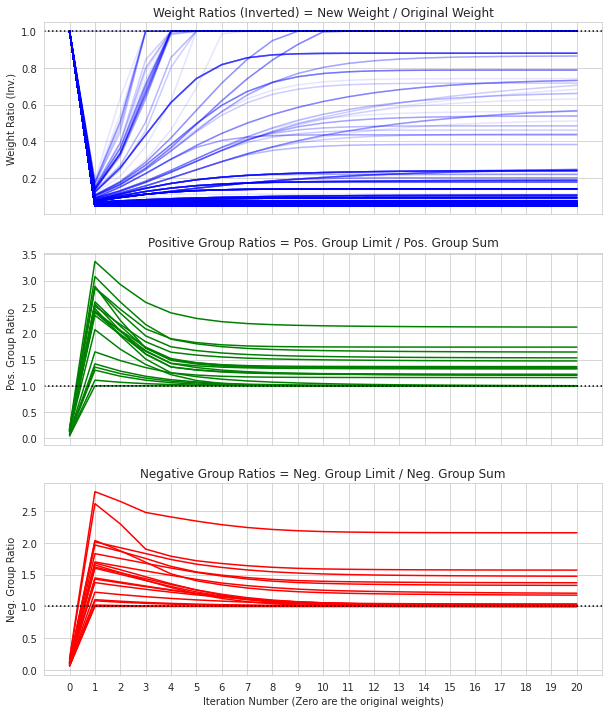

In [34]:
# Create a figure with the log's weight-ratios and group-ratios.
fig = grp.plot_log(weights_org=weights_org,
                   weights_new_log=weights_new_log,
                   all_xticks=True, rasterized=True)

# Save the figure to a file.
filename = 'Portfolio Group Constraints - Convergence Log.svg'
filename = os.path.join(path_plots, filename)
fig.savefig(filename, bbox_inches='tight')

# Show the figure here.
fig;

## Time Usage

Perform thousands of trials with random portfolios to measure the actual time-usage.

In [35]:
# Use the functions once to compile with Numba Jit,
# otherwise it could distort the timing tests below.

# Generate a random portfolio.
grp, weights_org = rand_portfolio(num_assets=100, num_groups=10)

# Calculate the constrained portfolio weights.
weights_new = grp.constrain_weights(weights_org=weights_org)

In [36]:
# Names used in log of results.
NUM_ASSETS = 'Num Assets'
NUM_GROUPS = 'Num Groups'
TIME = 'Time / msec'

In [37]:
def log_append(num_assets, num_groups, start_time, end_time):
    """
    Append the results to the log.

    :param num_assets: Int with number of portfolio assets.
    :param num_groups: Int with number of groups.
    :param start_time: Float with start-time.
    :param end_time: Float with end-time.
    :return: None
    """
    log_data = \
    {
        NUM_ASSETS: num_assets,
        NUM_GROUPS: num_groups,
        TIME: (end_time - start_time) * 1000,
    }
    log.append(log_data)

In [38]:
# Number of assets in each random portfolio.
num_assets = [50, 100, 250, 500, 750, 1000, 1250, 1500, 1750, 2000]

# Number of groups in each random portfolio.
num_groups = [1, 10, 50, 100, 200, 300, 400, 500]

# Min / max number of random trials for each portfolio config.
min_trials = 10
max_trials = 100

# Max iterations for the group-constraint algorithm.
max_iter = 30

In [39]:
%%time
# Initialize log with results.
log = []

# For each number of assets in the portfolio.
for n in num_assets:
    # For each number of groups.
    for g in num_groups:
        # Initialize sum of time-usage.
        sum_time = 0

        # Initialize number of random trials performed.
        num_trials = 0

        # Repeat until enough random trials have been performed.
        while num_trials < max_trials:
            # Print status.
            print(f'num_assets={n}, num_groups={g}      ', end='\r')

            # Generate random portfolio.
            # We don't measure the time used to initialize the solver.
            grp, weights_org = rand_portfolio(num_assets=n, num_groups=g)

            # Time the group-constraint algorithm on this portfolio.
            start_time = time()
            weights_new = grp.constrain_weights(weights_org=weights_org, max_iter=max_iter)
            end_time = time()
            sum_time += end_time - start_time
            log_append(num_assets=n, num_groups=g,
                       start_time=start_time, end_time=end_time)

            # Increase number of trials performed.
            num_trials += 1

            # Break out of for-loop if spent more than 1 second.
            if num_trials > min_trials and sum_time > 1:
                break

# Convert log to Pandas DataFrame.
df_log = pd.DataFrame(log)

# Show the first rows of the log.
df_log.head()

CPU times: user 14min 10s, sys: 3.46 s, total: 14min 14s
Wall time: 14min 8s


,Num Assets,Num Groups,Time / msec
0,50,1,2.515793
1,50,1,3.270626
2,50,1,2.907753
3,50,1,3.332376
4,50,1,2.494097


In [40]:
# Stats for num trials per combination of num_assets and num_groups.
df_log.groupby([NUM_ASSETS, NUM_GROUPS]).apply(lambda df: len(df)).describe()

count     80.000000
mean      99.712500
std        1.608472
min       89.000000
25%      100.000000
50%      100.000000
75%      100.000000
max      100.000000
dtype: float64

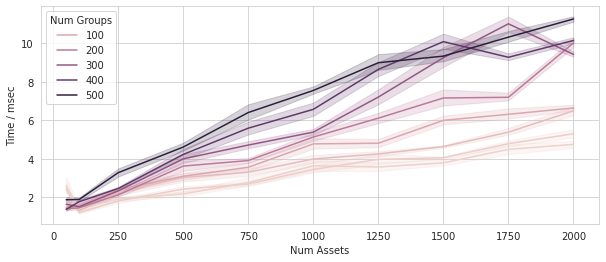

In [41]:
# Plot time-usage with num_assets on x-axis and num_groups as hue.

# Create figure.
fig, ax = plt.subplots(figsize=figsize_small)

# Plot the data.
sns.lineplot(data=df_log, x=NUM_ASSETS, y=TIME, hue=NUM_GROUPS,
             ci=99, ax=ax);

# Save plot to a file.
filename = 'Time-Usage Comparison (x = Num Assets).svg'
filename = os.path.join(path_plots, filename)
fig.savefig(filename, bbox_inches='tight')

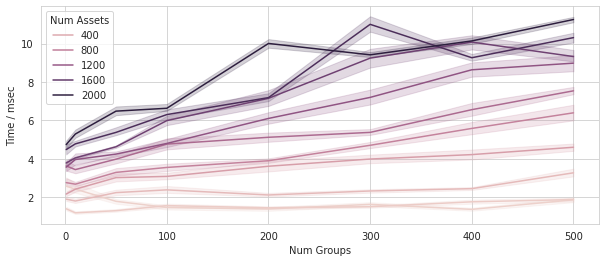

In [42]:
# Plot time-usage with num_groups on x-axis and num_assets as hue.

# Create figure.
fig, ax = plt.subplots(figsize=figsize_small)

# Plot the data.
sns.lineplot(data=df_log, x=NUM_GROUPS, y=TIME, hue=NUM_ASSETS,
             ci=99, ax=ax);

# Save plot to a file.
filename = 'Time-Usage Comparison (x = Num Groups).svg'
filename = os.path.join(path_plots, filename)
fig.savefig(filename, bbox_inches='tight')

## License (MIT)

Copyright (c) 2022 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.